# Libraries

In [5]:
import numpy as np
from textblob import TextBlob
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

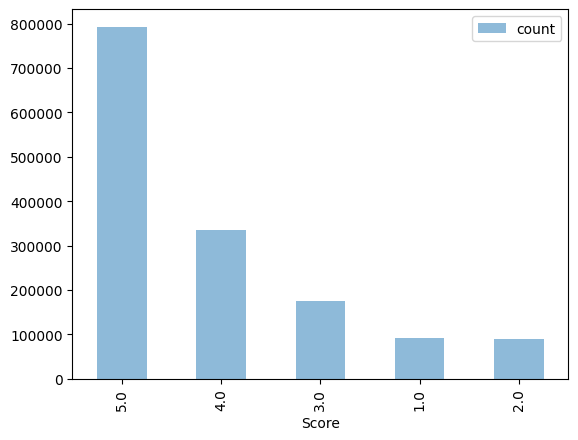


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [6]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [28]:
from textblob import TextBlob  # Import TextBlob for sentiment analysis

def add_features_to(df, training_data=None):
    # Basic helpfulness ratio
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    # Enhanced helpfulness features
    df['IsHelpful'] = (df['HelpfulnessNumerator'] > 0).astype(int)
    df['HelpfulnessDifference'] = df['HelpfulnessNumerator'] - df['HelpfulnessDenominator']
    df['WeightedHelpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    
    # Time-based features
    time_series = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = time_series.dt.year
    df['Month'] = time_series.dt.month
    df['DayOfWeek'] = time_series.dt.dayofweek
    df['Quarter'] = time_series.dt.quarter
    
    # Text-based features
    df['Text'] = df['Text'].fillna("").astype(str)  # Fill missing values with empty string and convert to str
    df['ReviewLength'] = df['Text'].apply(lambda x: len(x.split()))
    df['UniqueWords'] = df['Text'].apply(lambda x: len(set(x.split())))
    df['AverageWordLength'] = df['Text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)

    # Sentiment analysis
    df['Sentiment'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # User and Product history features
    if training_data is not None:
        user_means = training_data.groupby('UserId')['Score'].mean()
        product_means = training_data.groupby('ProductId')['Score'].mean()
        global_mean = training_data['Score'].mean()
        user_avg_polarity = training_data.groupby('UserId')['Sentiment'].mean()
    else:
        user_means = df.groupby('UserId')['Score'].mean()
        product_means = df.groupby('ProductId')['Score'].mean()
        global_mean = df['Score'].mean()
        user_avg_polarity = df.groupby('UserId')['Sentiment'].mean()
    
    df['UserMeanScore'] = df['UserId'].map(user_means)
    df['ProductMeanScore'] = df['ProductId'].map(product_means)
    df['UserMedianScore'] = df['UserId'].map(training_data.groupby('UserId')['Score'].median() if training_data is not None else df.groupby('UserId')['Score'].median())
    df['UserReviewCount'] = df['UserId'].map(training_data.groupby('UserId')['Score'].count() if training_data is not None else df.groupby('UserId')['Score'].count()).fillna(0)
    
    # Fill missing values with global mean
    df['UserMeanScore'] = df['UserMeanScore'].fillna(global_mean)
    df['ProductMeanScore'] = df['ProductMeanScore'].fillna(global_mean)
    
    # Interaction term
    df['UserProductInteraction'] = df['UserMeanScore'] * df['ProductMeanScore']
    
    # User-based polarity (average sentiment of the user's reviews)
    df['UserPolarity'] = df['UserId'].map(user_avg_polarity).fillna(0)  # Fill missing polarity with 0 (neutral)
    
    return df


# Loading and processing the data
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    
    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    
    # Add features to submission set using training data statistics
    X_submission = add_features_to(X_submission, trainingSet)
    
    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]
    
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)


# Sample + Split into training and testing set

In [52]:
from sklearn.model_selection import train_test_split

# Split the training data into features and target variable
# Assuming that 'Score' is the column with the target values
X = X_train.drop(columns=['Score'])
Y = X_train['Score']

# Split the training set into training and testing sets for offline evaluation
X_train, X_test, Y_train, Y_test = train_test_split(
    X,  # Features (excluding 'Score')
    Y,  # Target variable ('Score')
    test_size=0.25,  # 25% of the data will be used as the testing set
    random_state=0  # For reproducibility of results
)

# Check the dimensions of the resulting datasets
print(f"Training Set Shape: X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Testing Set Shape: X_test: {X_test.shape}, Y_test: {Y_test.shape}")


Training Set Shape: X_train: (1114005, 27), Y_train: (1114005,)
Testing Set Shape: X_test: (371336, 27), Y_test: (371336,)


# Feature Selection

In [53]:
from sklearn.preprocessing import StandardScaler
# Updated feature list with all additional features

features = [
    'HelpfulnessNumerator',
    'HelpfulnessDenominator',
    'Helpfulness',
    'IsHelpful',
    'HelpfulnessDifference',
    'WeightedHelpfulness',
    'Year',
    'Month',
    'DayOfWeek',
    'Quarter',
    'UserMeanScore',
    'ProductMeanScore',
    'UserMedianScore',
    'UserReviewCount',
    'UserProductInteraction',
    'ReviewLength',
    'UniqueWords',
    'AverageWordLength',
    'Sentiment',
    'UserPolarity'
]

# Selecting features for training and testing
X_train_select = X_train[features]
X_test_select = X_test[features]  # Assuming X_test has been defined similarly
X_submission_select = X_submission[features]






# Model Creation

In [62]:
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier(max_iter = 100, learning_rate=0.25, max_leaf_nodes=31, random_state=42)
model.fit(X_train_select, Y_train)

Y_test_predictions = model.predict(X_test_select)


# Model Evaluation

Accuracy on testing set =  0.6533462955382726


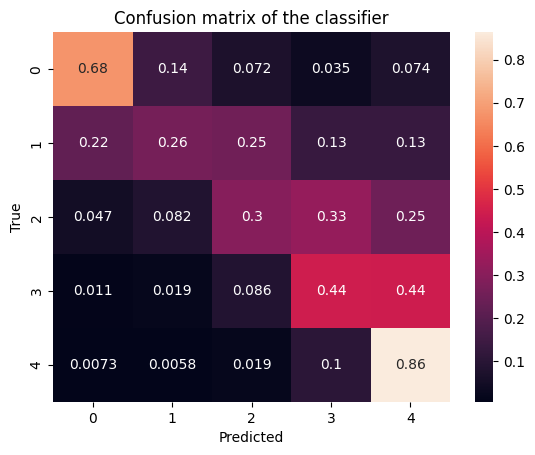

In [65]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#best score: 0.6519028588663636


# Create submission file

In [66]:
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)